# Question 1
Consider the tax functions we saw in class as an example of multiple dispatch. 

In [1]:
struct SimpleTax
end 

struct ComplexTax 
α::Float64
end

In [2]:
t1 = SimpleTax() 
t2 = ComplexTax(0.3)
tax(y, t::SimpleTax) = 0.5*y
tax(y, t::ComplexTax) = y^t.α
consumption(y, t) = y - tax(y, t)

consumption (generic function with 1 method)

In [3]:
consumption(0.5, t2)

-0.3122523963562356

Define a new tax structure with 3 parameters and associated tax function. Call this struct ProgTax. You should implement the tax function of Gouveia and Strauss (1994), which is 

$$\alpha_0 [y - (y^{-\alpha_1} + \alpha_2)^{-1/\alpha_1}] $$

Construct an instance of ProgTax with parameters $\alpha_0, \alpha_1, \alpha_2$ equal to $0.2, 0.7$, and $0.5$ respectively. Evaluate the consumption function at 0.5 with these taxes.

Plot this tax function on the range `0:0.1:2` . What is its shape?

In [4]:
## Do work here
struct ProgTax
    α_0::Float64
    α_1::Float64
    α_2::Float64
end

function tax(y, t::ProgTax) 
    α_0, α_1, α_2 = t.α_0, t.α_1, t.α_2
    # α_0(y - (y^-α_1 + α_2)^(-1/α_1)) Not ok. It will try to call α_0 like a function 
    # 3.5(y - (y^-α_1 + α_2)^(-1/α_1)) Is ok. Special syntax for number constants on parentheses 
    α_0*(y - (y^-α_1 + α_2)^(-1/α_1))
end
t3 = ProgTax(0.2, 0.7, 0.5)
tax(.5, t3)

0.03184166480482619

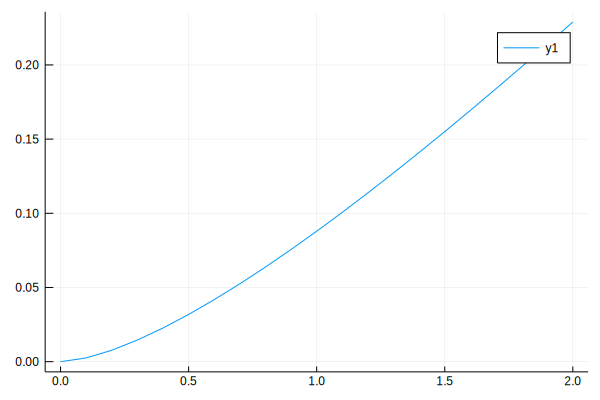

In [5]:
x = 0:0.1:2
y = [tax(xi, t3) for xi in x]
using Plots
plot(x, y)

# Some comments on parameters
We often have parameters stored in some structure, and we'll want to use them in our functions. We also want an easy way to modify parameters so we can solve our model with something other than the default, like when we want to plot the solution over a range of parameter values.

The parameters package provides some helpful macros to help with this.

In [6]:
]add Parameters

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]


In [7]:
using Parameters
function tax(y, t::ProgTax) 
    #α_0, α_1, α_2 = t.α_0, t.α_1, t.α_2 Equivalent to the following
    @unpack α_0, α_1, α_2 = t
    α_0*(y - (y^-α_1 + α_2)^(-1/α_1))
end

tax (generic function with 3 methods)

The `@unpack` macro rewrites the code to minimize typing and stop you from making a mistake, like swapping a subscript.

Another problem we want to avoid is forgetting the order we wrote our parameters, for example, above we wrote `t3 = ProgTax(0.2, 0.7, 0.5)`. Here we used the fact that the order was `α_0, α_1, α_2`. What if this was a complicated model with 10 or 20 parameters? We might make a mistake, causing bugs in our code. Making liberal use of keywords will prevent this.

In [8]:
# This macro enables keyword construction of this struct
Base.@kwdef struct ProgTax
    α_0::Float64
    α_1::Float64
    α_2::Float64
end
t3 = ProgTax(α_0 = 0.2, α_1 = 0.7, α_2 = 0.5)

ProgTax(0.2, 0.7, 0.5)

In [9]:
# Order no longer matters!
ProgTax(α_2 = 0.5, α_1 = 0.7, α_0 = 0.2)

ProgTax(0.2, 0.7, 0.5)

In [10]:
# It's also possible to define defaults
Base.@kwdef struct ProgTax
    α_0::Float64 = 0.2
    α_1::Float64 = 0.7
    α_2::Float64 = 0.5
end
t3 = ProgTax()

ProgTax(0.2, 0.7, 0.5)

In [11]:
t3_new = ProgTax(α_0 = 0.6)

ProgTax(0.6, 0.7, 0.5)

One more thing. I made `ProgTax` a struct specifically because I needed to use multiple dispatch over different tax funcions. If this was single use code, I might simplify the code a bit by using named tuples instead of structs. QuantEcon likes to use this style. 

In [12]:
tax_params = (α_0 = 0.2, α_1 = 0.7, α_2 = 0.5)
function tax2(y, tp)
    @unpack α_0, α_1, α_2 = tp
    α_0*(y - (y^-α_1 + α_2)^(-1/α_1))
end
tax2(0.5, tax_params)

0.03184166480482619

In [13]:
# We can do similar default keyword stuff with this @with_kw macro.
Tax_params = @with_kw (α_0 = 0.2, α_1 = 0.7, α_2 = 0.5)
tax_params = Tax_params()
tax_params = Tax_params(α_0 = 0.6)

(α_0 = 0.6, α_1 = 0.7, α_2 = 0.5)

# Question 2

Consider the econometrics simulation from before. We are going to check the performance under different assumptions. I repeat the code below.

In [14]:
using Random
Random.seed!(5);

In [15]:
using Distributions
using Statistics # the var function is in the Statistics package
N = 25
X = rand(N, 2)
X = [ones(N, 1) X]
beta = [5
2
3]

3-element Array{Int64,1}:
 5
 2
 3

In [16]:
dist = Normal()
u = rand(dist, N)
Y = X*beta + u
betahat = (X' * X)\(X' * Y)
eps = Y - X*betahat
sigma_eps = 1 # Why not var(eps)
betahat_var = (X' * X)^-1 * sigma_eps
CI = (β_2_lower = betahat[2] - 1.96*sqrt(betahat_var[2, 2]), 
    β_2_upper = betahat[2] + 1.96*sqrt(betahat_var[2, 2]))

(β_2_lower = 0.6903147187462937, β_2_upper = 3.413317882542308)

This was a confidence interval according to the OLS formula, which is valid under certain assumptions. Let's create the exact interval by simulation (Monte Carlo).

In [17]:
function simulate_beta(X, dist, N)
beta = [5
2
3]
u = rand(dist, N)
Y = X*beta + u
betahat = (X' * X)\(X' * Y)
end
function simulate_CI(X, dist, N, N_sim)
    betas = [simulate_beta(X, dist, N)[2] for i in 1:N_sim]
    (β_2_lower = quantile(betas, 0.025), β_2_upper = quantile(betas, 0.975), betas = betas)
end

simulate_CI (generic function with 1 method)

In [18]:
CI2 = simulate_CI(X, dist, N, 10000)

(β_2_lower = 0.6378545148623046, β_2_upper = 3.3514168266203685, betas = [2.949344785571887, 1.384039932266179, 2.422804237671619, 1.503965941778842, 1.7867336115253918, 1.5432487481825925, 2.2789768621298383, 2.7357262506017896, 1.2389097606496031, 2.372727567960807  …  1.5632432074552582, 1.6715104603590576, 2.0862835867738547, 1.3574067064131214, 1.471143367043015, 0.3418417504414301, 2.6460500044363835, 1.7504516599861233, 2.7305850344392324, 1.184955764699225])

Compute the width (upper minus lower) of each CI. Are they similar?

Pick a distribution other than Normal, but make sure it still has mean 0 and variance 1. Verify this with the Distributions package.

Repeat the exercise. Are the widths similar?

In [19]:
width1 = CI.β_2_upper - CI.β_2_lower

2.7230031637960144

In [20]:
width2 = CI2.β_2_upper - CI2.β_2_lower

2.713562311758064

They look pretty similar. This makes sense. We know that under the OLS assumptions, the variance matrix of the beta coefficients is given by $\Sigma = (X'X)^{-1} \sigma_u^2$. 

Additionally, if the error is normal, then the beta coefficients have a multivariate normal distribution. This is true even without an assumption of normally distributed errors in large samples, as you will learn this semester in econometrics. To see this even more clearly, look at the histogram.

std(CI2.betas) = 0.693122606471447


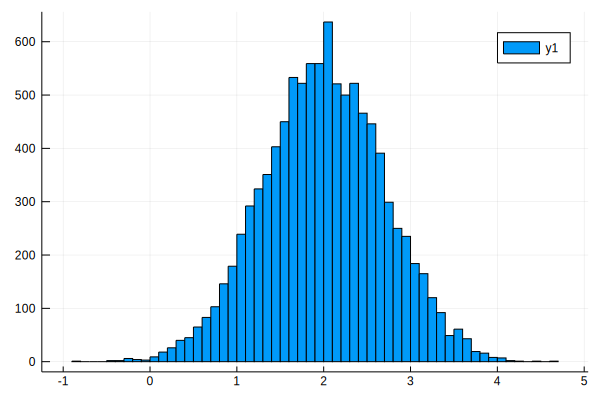

In [21]:
@show std(CI2.betas)
histogram(CI2.betas)

In [22]:
## Let's repeat the exercise for an exponential distribution. 
dist = Exponential(5)
# Check it has mean 0 and variance 1 
@show mean(dist)
@show var(dist)

mean(dist) = 5.0
var(dist) = 25.0


25.0

It doesn't have variance 1. Let's scale it so that it does have variance 1. The Distributions package provides a LocationScale distribution for this transformation.

In [23]:
stde = std(Exponential(5))
meane = mean(Exponential(5))
dist1 = LocationScale(0, 1/stde, Exponential(5))
dist = LocationScale(-mean(dist1), 1/stde, Exponential(5))
@show mean(dist)
@show var(dist)

mean(dist) = 0.0
var(dist) = 1.0000000000000002


1.0000000000000002

In [24]:
typeof(dist)

LocationScale{Float64,Exponential{Float64}}

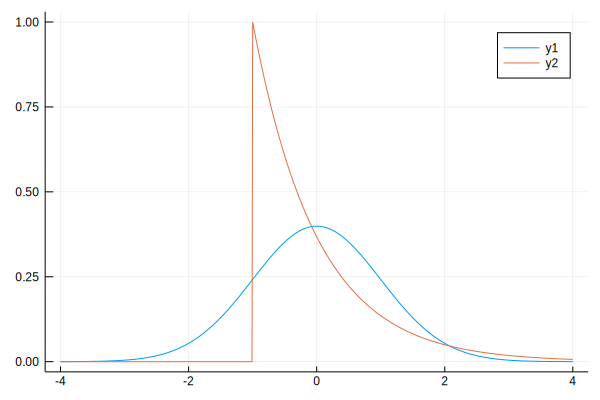

In [25]:
# We can even plot it to look at the unusual shape of this new distribution.
ndist = Normal()
x = -4:0.01:4
y1 = [pdf(ndist, xi) for xi in x]
y2 = [pdf(dist, xi) for xi in x]
plt = plot()
plot!(plt, x, y1)
plot!(plt, x, y2)

In [26]:
## Copied from before
u = rand(dist, N)
Y = X*beta + u
betahat = (X' * X)\(X' * Y)
eps = Y - X*betahat
sigma_eps = 1 # Why not var(eps)
betahat_var = (X' * X)^-1 * sigma_eps
CI = (β_2_lower = betahat[2] - 1.96*sqrt(betahat_var[2, 2]), 
    β_2_upper = betahat[2] + 1.96*sqrt(betahat_var[2, 2]))

CI2 = simulate_CI(X, dist, N, 10000)

(β_2_lower = 0.5834809928349727, β_2_upper = 3.336621025643279, betas = [2.6595435045745144, 1.0502263719011977, 2.560118385222289, 2.791904177322004, 2.763440188068668, 2.163307945905521, 1.7246499449202544, 3.0469810982033128, 2.2895078061556413, 1.3251320269610305  …  2.057720822644204, 2.991479312960306, 2.4302015888556823, 1.769886094131091, 2.1291618738221905, 1.729598222595364, 2.2441015072694763, 1.6191917421698068, 2.0601604651835657, 2.459136894636001])

In [27]:
width1 = CI.β_2_upper - CI.β_2_lower

2.7230031637960135

In [28]:
width2 = CI2.β_2_upper - CI2.β_2_lower

2.7531400328083064

std(CI2.betas) = 0.6911111521979715


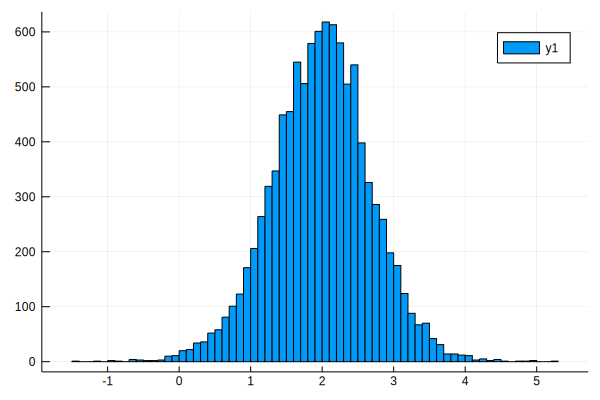

In [29]:
@show std(CI2.betas)
histogram(CI2.betas)

We see that the analytical confidence interval is still about the same width as the (true) simulated one. This is not altogether surprising, since the OLS assumptions are satisfied. Normally distributed errors is not an OLS assumption, though you need large samples (central limit theorem) to get normally distributed beta estimates.

Let's try violating the OLS assumptions by introducing correlated errors. Suppose we still have a sample size of 100, but we drew 50 observations from group 1, and 50 observations from group 2. The error structure is 

$$ u_{ig} = \alpha_g + \varepsilon_{ig} $$

Let's suppose $\alpha_g$ and $\varepsilon_{ig}$ are both drawn from Normal distributions with mean 0 and variance 0.5, and these draws are independent. Then $Var(u_{ig}) = Var(\alpha_g) + Var(\varepsilon_{ig})$, so $Var(u_{ig}) = 1$

We want to sample from this distribution for the errors, but there's nothing which represents this situation in the Distributions package. Therefore, we will define our own method of `rand` to sample from this distribution. Thanks to multiple dispatch, our code from above will still work unchanged.

In [30]:
struct MyGroupDist
    σ_g::Float64
    σ_ε::Float64
end

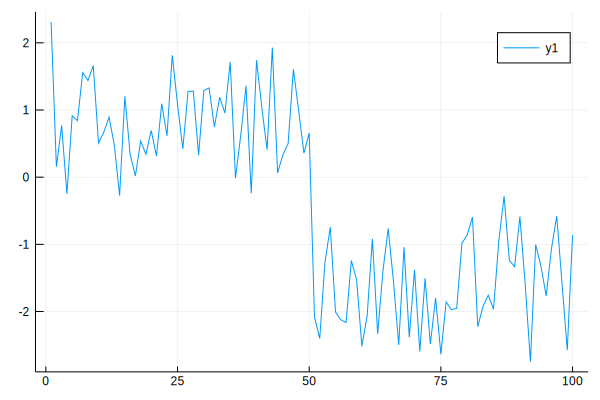

In [31]:
import Base.rand # It won't let you add methods to Base functions like rand without this. 
function rand(dist::MyGroupDist, N::Int) # The ::Int was actually required here
    gdist = Normal(0, dist.σ_g)
    εdist = Normal(0, dist.σ_ε)
    group1N = N÷2 # This is integer division. It will return an integer even if N is odd.
    group2N = N - group1N
    g1 = rand(gdist)
    g2 = rand(gdist)
    u1 = rand(εdist, group1N) .+ g1
    u2 = rand(εdist, group2N) .+ g2
    [u1
    u2]
end

Random.seed!(3)
dist = MyGroupDist(sqrt(0.5), sqrt(0.5))
plot(1:100, rand(dist, 100)) # Observe the correlation

Quick technical point: I showed analytically above that $Var(u_{ig}) = 1$. How would we show this by simulation? You might think we could just compute the sample variance of a random sample of say, 1 million, but this is not the right computation.

In [32]:
var(rand(dist, 1_000_000)) # Probably not 1

0.6951834901022088

The problem is that even though the number of observations is going to $\infty$, we still only make 2 draws from the group distribution. It's like we have 2 schools, each with 500,000 students, but within a school they're pretty similar. We need to make IID draws if we want to estimate population parameters. That means each draw should have a new group and a new individual. 

In [33]:
us = [rand(dist, 2)[1] for i = 1:10000] # Draw 2 schools and 2 students, pick the first one
var(us)

0.9773070122194224

In [34]:
Random.seed!(3)
## Copied from before
u = rand(dist, N)
Y = X*beta + u
betahat = (X' * X)\(X' * Y)
eps = Y - X*betahat
sigma_eps = 1 # Variance of u, from formula
betahat_var = (X' * X)^-1 * sigma_eps
CI = (β_2_lower = betahat[2] - 1.96*sqrt(betahat_var[2, 2]), 
    β_2_upper = betahat[2] + 1.96*sqrt(betahat_var[2, 2]))

CI2 = simulate_CI(X, dist, N, 10000)

(β_2_lower = 0.8700680810362907, β_2_upper = 3.1568781238022607, betas = [1.8154100070282855, 1.839385690994357, 2.209195887726376, 2.28075899780158, 2.512259197931411, 2.7089514443519507, 1.5662728011814482, 1.9256154590565038, 0.6642743405714009, 1.6218529019917807  …  2.4805487725736706, 1.3915729361342861, 2.9305303096858517, 1.7344723742681343, -0.10496903649327428, 1.7270906039786194, 1.450301899229222, 2.261880107361716, 1.8290917756838319, 1.9207550718984534])

In [35]:
width1 = CI.β_2_upper - CI.β_2_lower

2.7230031637960135

In [36]:
width2 = CI2.β_2_upper - CI2.β_2_lower

2.28681004276597

std(CI2.betas) = 0.5841221375161194


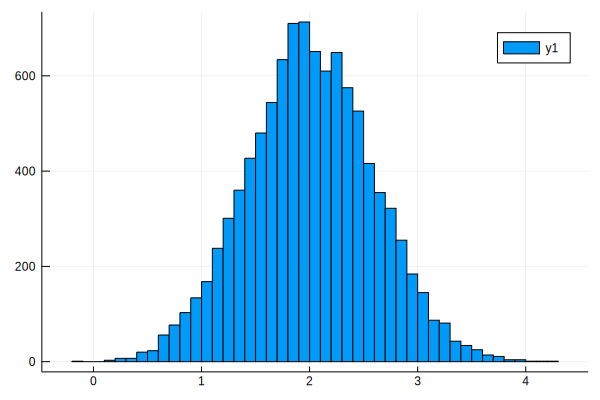

In [37]:
@show std(CI2.betas)
histogram(CI2.betas)